In [96]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 400
plt.rcParams['axes.grid'] = True
plt.rcParams['image.aspect'] = 0.8

import numpy as np
import casadi as ca
from helper_fns import yaml_load

nlpopts = { "print_time":False,      # Prints the time for evaluating objective, calculating gradients, etc
            "ipopt.print_level":0,   # Integer from 0 to 5, 5 printing the most information
            "ipopt.tol":1.0e-5,
            "ipopt.acceptable_constr_viol_tol":2.0e-04,
            "ipopt.warm_start_init_point":"yes",
            "ipopt.warm_start_bound_frac":1.0e-09,
            "ipopt.warm_start_bound_push":1.0e-09,
          }

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [98]:
from robot import Robot
from contact import Contact
from impedance_controller import ImpedanceController
from decision_vars import DecisionVarSet
par = {'pos': [0, 0, 0.0],
       'stiff': [0, 0, 3e4],
        'rest':[0, 0, 0.7]}
attrs = yaml_load('config/attrs.yaml')
attrs = {k:attrs[k] for k in ['lb', 'ub']}
c = Contact('c/', par, [], attrs=attrs)
imp = ImpedanceController(input_vars = ['imp_rest'], attrs = attrs)
rob = Robot('config/franka.urdf', subsys = [c], ctrl = imp, attrs = attrs, visc_fric = 100)

Building robot model from config/franka.urdf with TCP fr3_link8
  with subsys ['c/']
  with control imp_ctrl


In [101]:
from mpc import MPC
from helper_fns import mult_shoot_rollout
from robot import *

mpc = MPC(robots={'free':rob}, mpc_params={'H':25, 'dt':0.05, 'vel_cost':0.05, 'des_pose':[0.3, 0.5, 0.8]}, nlpopts =nlpopts)
params = {'q': ca.DM.zeros(7),
          'dq': ca.DM.zeros(7),
          'belief_free':1.0, 
          'imp_stiff':400*ca.DM.ones(3),}
res = mpc.solve(params)
res['imp_stiff'] = params['imp_stiff']
traj = rob.get_ext_state(res)


***** Decision Vars *****
Attributes: ['lb', 'ub']
Vars: 
  imp_rest: 
[[imp_rest_0, imp_rest_3, imp_rest_6, imp_rest_9, imp_rest_12, imp_rest_15, imp_rest_18, imp_rest_21, imp_rest_24, imp_rest_27, imp_rest_30, imp_rest_33, imp_rest_36, imp_rest_39, imp_rest_42, imp_rest_45, imp_rest_48, imp_rest_51, imp_rest_54, imp_rest_57, imp_rest_60, imp_rest_63, imp_rest_66, imp_rest_69, imp_rest_72], 
 [imp_rest_1, imp_rest_4, imp_rest_7, imp_rest_10, imp_rest_13, imp_rest_16, imp_rest_19, imp_rest_22, imp_rest_25, imp_rest_28, imp_rest_31, imp_rest_34, imp_rest_37, imp_rest_40, imp_rest_43, imp_rest_46, imp_rest_49, imp_rest_52, imp_rest_55, imp_rest_58, imp_rest_61, imp_rest_64, imp_rest_67, imp_rest_70, imp_rest_73], 
 [imp_rest_2, imp_rest_5, imp_rest_8, imp_rest_11, imp_rest_14, imp_rest_17, imp_rest_20, imp_rest_23, imp_rest_26, imp_rest_29, imp_rest_32, imp_rest_35, imp_rest_38, imp_rest_41, imp_rest_44, imp_rest_47, imp_rest_50, imp_rest_53, imp_rest_56, imp_rest_59, imp_rest_62, imp_re

KeyError: 'q'

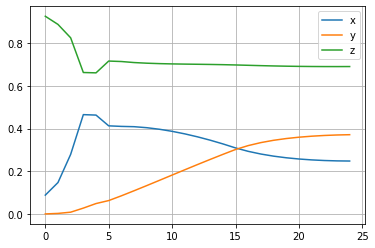

In [92]:
import matplotlib.pyplot as plt
import numpy as np

p = np.squeeze(np.array(traj['p'].T))
plt.plot(p, label=['x', 'y', 'z'])
plt.legend()

In [81]:
import time
N = 100
times = []

for _ in range(N):
    params['q'] += 0.05*np.random.randn(7) # perturb initial state
    tic = time.perf_counter()
    sol = mpc.solve(params)
    times.append(time.perf_counter()-tic)
    
print(f'Cold start time:  {times[0]} sec')
print(f'Cold start rate:  {1/times[0]} Hz')
print(f'Warm start rate: {1/np.mean(times[1:])} Hz')

Cold start time:  0.09227350004948676 sec
Cold start rate:  10.837347661719722 Hz
Warm start rate: 24.398480118014295 Hz


In [39]:
from robot import Robot
from contact import Contact
from impedance_controller import ImpedanceController
from decision_vars import DecisionVarSet
par = {'pos': [0, 0, 0.0],
       'stiff': [0, 0, 3e4],
        'rest':[0, 0, 0.7]}
attrs = yaml_load('config/attrs.yaml')
attrs = {k:attrs[k] for k in ['lb', 'ub']}
imp = ImpedanceController(input_vars = ['imp_rest'],
                          attrs = attrs)
rob = Robot('config/franka.urdf', subsys = [], ctrl = imp, attrs = attrs, visc_fric = 100)
rob.build_step(0.1)
rob.build_rollout(10, 20)

M_inv = rob.inv_mass_fn(np.zeros(7))
#%timeit rob.rollout_red(np.zeros(14), np.zeros(3))
#%timeit rob.rollout(np.zeros(14), np.zeros(3), np.zeros(3))

# 31.2 us
%timeit rob.rollout(np.zeros(14), np.zeros(3), np.ones(3))
# 81.5 us for 20 samples
%timeit rob.rollout_map(np.zeros((14,20)), np.zeros(3), np.zeros(3))

Building robot model from config/franka.urdf with TCP fr3_link8
  with control imp_ctrl
33.8 µs ± 4.84 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
85.5 µs ± 3.69 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
